<a href="https://colab.research.google.com/github/codewithdark-git/AutoEncoder/blob/main/VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder (VAE)

This notebook demonstrates the implementation and training of a Variational Autoencoder (VAE) using PyTorch. A VAE is a generative model that learns a probabilistic mapping from the input data to a latent space, allowing for the generation of new data samples.

![](https://eugeneyan.com/assets/variational-autoencoder.webp)

## Variational Autoencoder (VAE) Concept

A Variational Autoencoder (VAE) is a type of generative model that builds upon the Autoencoder architecture. While a standard autoencoder learns a mapping to a fixed point in the latent space, a VAE learns a mapping to a probability distribution over the latent space. This probabilistic approach allows VAEs to generate new data samples by sampling from the learned distributions.

The key difference lies in the encoder. Instead of outputting a single latent vector, the VAE encoder outputs two vectors for each input:

1.  **Mean (\$\mu\$):** This vector represents the mean of the learned latent distribution for the input data.
2.  **Log Variance (\$\log\_var\$):** This vector represents the logarithm of the variance of the learned latent distribution. The log variance is typically used instead of the variance directly for numerical stability.

These two vectors define a probability distribution (usually assumed to be a Gaussian distribution) in the latent space for each input data point.

During training, the VAE aims to achieve two goals simultaneously:

1.  **Reconstruction:** Like a standard autoencoder, the decoder must be able to reconstruct the original input data from a sample drawn from the learned latent distribution.
2.  **Regularization:** The learned latent distributions for all input data points should be regularized to be close to a standard normal distribution (mean 0, variance 1). This encourages a smooth and continuous latent space, which is essential for generating realistic new data.

The regularization is achieved by adding a Kullback-Leibler Divergence (KLD) term to the loss function. The KLD measures the difference between the learned latent distribution and a standard normal distribution. Minimizing the KLD encourages the encoder to produce latent distributions that are centered around zero and have a variance close to one.

The **Reparameterization Trick** is a crucial technique used in VAEs to enable backpropagation through the sampling process. Instead of directly sampling from the distribution defined by \$\mu\$ and \$\log\_var\$, a sample \$z\$ is generated as follows:

$ z = \mu + \epsilon \cdot \exp(0.5 \cdot \log\_var) $

where \$\epsilon\$ is a sample from a standard normal distribution (\$\mathcal{N}(0, I)\$). This reparameterization allows the gradients to flow through \$\mu\$ and \$\log\_var\$, making the model trainable using gradient-based optimization methods.

The decoder then takes this sampled latent vector \$z\$ and reconstructs the input data. The overall loss function of the VAE combines the reconstruction loss (e.g., Binary Cross-Entropy for images) and the KLD regularization term.

## Variational Autoencoder (VAE) Loss Formula

The loss function for a Variational Autoencoder (VAE) is a combination of two terms:

1.  **Reconstruction Loss:** This term measures how well the decoder reconstructs the original input from the sampled latent vector. For image data like MNIST, Binary Cross-Entropy (BCE) is commonly used as the reconstruction loss. Given an input \$x\$ and its reconstruction \$\hat{x}\$, the BCE loss is calculated as:

$$
L_{recon}(x, \hat{x}) = -\sum_{i} [x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i)]
$$
    where `i` iterates over the pixels of the image.

2.  **Kullback-Leibler Divergence (KLD) Loss:** This term acts as a regularizer, encouraging the learned latent distribution \$q(z|x)\$ (output by the encoder) to be close to a standard normal distribution \$p(z)\$ (\$\mathcal{N}(0, I)\$). For a Gaussian latent distribution with mean \$\mu\$ and log variance \$\log\_var\$, the KLD loss is given by:

    \$L_{KLD}(\mu, \log\_var) = -0.5 \sum_{j=1}^{D} (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)\$

    where \$D\$ is the dimensionality of the latent space, \$\mu_j\$ and \$\sigma_j^2 = \exp(\log\_var_j)\$ are the mean and variance of the \$j\$-th dimension of the latent distribution.

The total VAE loss is the sum of the reconstruction loss and the KLD loss:

\$L_{VAE}(x, \hat{x}, \mu, \log\_var) = L_{recon}(x, \hat{x}) + L_{KLD}(\mu, \log\_var)\$

The goal during training is to minimize this total VAE loss, which simultaneously improves the reconstruction quality and regularizes the latent space.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets


In [30]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True)
        )

        # Separate layers for mu and log_var
        self.fc_mu = nn.Linear(64, 12)
        self.fc_log_var = nn.Linear(64, 12)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 64), # Decoder starts from the latent dimension (12)
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        # Pass through the sequential encoder
        h = self.encoder(x)
        # Calculate mu and log_var
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)

        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std # Latent vector >> z = μ + ϵ * σ

        # Decode the latent vector
        decoded = self.decoder(z)
        return decoded, mu, log_var # Return reconstructed output, mu, and log_var

    # Also update the encode method to return mu and log_var
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets


In [32]:
# load the dataset

train_dataset = datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
def loss(output, target, mu, log_var, beta=1.0): # Add beta parameter with default value
    BCE = F.binary_cross_entropy(output, target, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + beta * KLD # Weight the KLD term by beta

In [38]:
num_epochs = 10 # Define num_epochs
beta = 0.001 # Initialize beta

for epoch in range(num_epochs): # Iterate up to num_epochs
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(device)
        optimizer.zero_grad()
        output, mu, log_var = model(data)
        vae_loss = loss(output, data, mu, log_var, beta) # Pass beta to the loss function
        vae_loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, vae_loss.item()))

epoch [1/10], loss:34769.0938
epoch [1/10], loss:13109.5576
epoch [1/10], loss:11740.0371
epoch [1/10], loss:10943.8311
epoch [1/10], loss:11185.4199
epoch [1/10], loss:10335.9600
epoch [1/10], loss:9653.3633
epoch [1/10], loss:8077.5430
epoch [1/10], loss:7941.4976
epoch [1/10], loss:8065.4268
epoch [2/10], loss:6969.2144
epoch [2/10], loss:7205.1934
epoch [2/10], loss:7418.2793
epoch [2/10], loss:7532.5684
epoch [2/10], loss:7472.6665
epoch [2/10], loss:6740.9360
epoch [2/10], loss:7216.4746
epoch [2/10], loss:6797.1582
epoch [2/10], loss:7417.2529
epoch [2/10], loss:6379.2339
epoch [3/10], loss:6777.3833
epoch [3/10], loss:6588.4268
epoch [3/10], loss:6588.4600
epoch [3/10], loss:6516.5732
epoch [3/10], loss:6769.0659
epoch [3/10], loss:6425.1465
epoch [3/10], loss:6211.3149
epoch [3/10], loss:6742.3027
epoch [3/10], loss:6556.2856
epoch [3/10], loss:6695.6729
epoch [4/10], loss:5768.3970
epoch [4/10], loss:6256.7480
epoch [4/10], loss:6184.3369
epoch [4/10], loss:5920.1743
epoch [4

## visualization



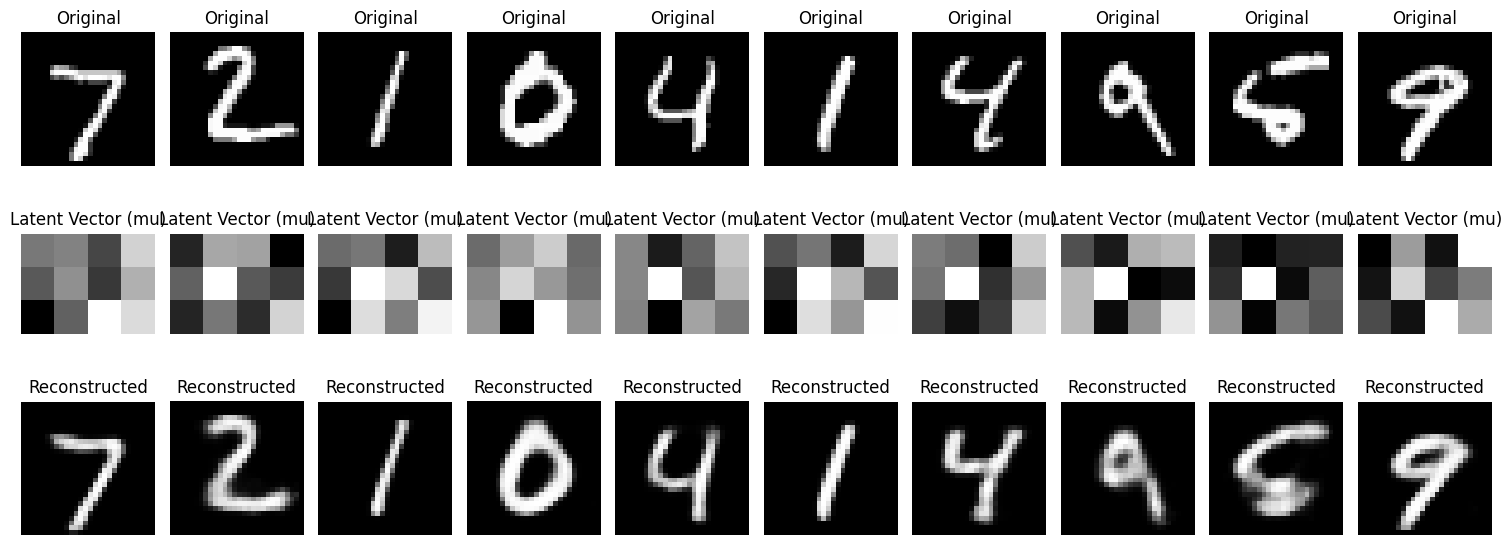

In [39]:
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()

# Disable gradient tracking
with torch.no_grad():
    n = 10
    plt.figure(figsize=(15, 6))

    for i in range(n):
        x = test_dataset[i][0]  # image tensor
        x_input = x.view(1, -1) # flatten if needed

        # Forward pass through encoder
        # The VAE model encode method now returns mu, log_var
        mu, log_var = model.encode(x_input)

        # Pass the latent vector (mu for deterministic visualization) to the decoder for reconstruction
        # In VAE visualization, we typically use the mean (mu) as the deterministic latent vector
        x_reconstructed = model.decoder(mu)

        # --- Original Image ---
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x.numpy().reshape(28, 28), cmap="gray")
        ax.set_title("Original")
        ax.axis("off")

        # --- Latent Representation (as a small image) ---
        ax = plt.subplot(3, n, i + 1 + n)
        # Reshape the 12-element latent vector (using mu for visualization) into a 3x4 grid
        latent_img = mu.squeeze().numpy().reshape(3, 4)
        plt.imshow(latent_img, cmap="gray", vmin=latent_img.min(), vmax=latent_img.max()) # Use cmap="gray" and set vmin/vmax
        ax.set_title("Latent Vector (mu)")
        ax.axis("off")

        # --- Reconstructed Image ---
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_reconstructed.numpy().reshape(28, 28), cmap="gray")
        ax.set_title("Reconstructed")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [40]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

def update(i):
    x = test_dataset[i][0]
    x_input = x.view(1, -1)

    mu, log_var = model.encode(x_input)
    x_reconstructed = model.decoder(mu)

    axs[0].clear()
    axs[1].clear()
    axs[2].clear()

    axs[0].imshow(x.numpy().reshape(28, 28), cmap="gray")
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Add .detach() before .numpy()
    latent_img = mu.squeeze().detach().numpy().reshape(3, 4)
    axs[1].imshow(latent_img, cmap="gray", vmin=latent_img.min(), vmax=latent_img.max())
    axs[1].set_title("Latent Vector")

    # Add .detach() before .numpy()
    reconstructed_img = x_reconstructed.squeeze().detach().numpy().reshape(28, 28)
    axs[2].imshow(reconstructed_img, cmap="gray")
    axs[2].set_title("Reconstructed")
    axs[2].axis("off")

ani = animation.FuncAnimation(fig, update, frames=10, repeat=False, interval=1500)

# Save the animation as a GIF and display it
ani.save('autoencoder_animation.gif', writer='pillow')
plt.close(fig) # Close the plot to prevent it from displaying twice


# Display the animation
HTML(ani.to_html5_video())

## Summary:

### Data Analysis Key Findings

*   The `AutoEncoder` class was successfully modified to include separate linear layers (`fc_mu` and `fc_log_var`) after the sequential encoder to output the mean (\$\mu\$) and log variance (\$\log\_var\$) of the latent space.
*   The reparameterization trick was correctly implemented in the `forward` method of the VAE model to sample from the latent space using the calculated mean and log variance.
*   The `forward` method was updated to return the reconstructed output, the mean (\$\mu\$), and the log variance (\$\log\_var\$), which are necessary for calculating the VAE loss.
*   A VAE loss function combining Binary Cross-Entropy (BCE) and Kullback-Leibler Divergence (KLD) was defined.
*   The training loop was successfully modified to use the VAE loss function with the returned \$\mu\$ and \$\log\_var\$ for backpropagation and optimization.
*   The visualization code was updated to display original images, a representation of the latent mean (\$\mu\$), and the reconstructed images generated by the VAE's decoder using the latent mean.

### Insights or Next Steps

*   The successful implementation of the VAE structure allows for generative capabilities and a more structured latent space compared to a standard autoencoder.
*   Further steps could involve exploring the generative aspect of the VAE by sampling from the latent space and decoding the samples to generate new images.
